In [1]:
import logging
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from iSDM.species import IUCNSpecies
turtles = IUCNSpecies(name_species='Pelusios rhodesianus')
turtles.load_shapefile('../data/FW_TURTLES/FW_TURTLES.shp')

Loading data from: ../data/FW_TURTLES/FW_TURTLES.shp
The shapefile contains data on 181 species.


In [3]:
turtles.find_species_occurrences()

Loaded species: ['Pelusios rhodesianus'] 


,binomial,category,citation,class_name,compiler,dist_comm,family_nam,genus_name,geometry,id_no,...,presence,seasonal,shape_area,shape_leng,source,species_na,subpop,subspecies,tax_comm,year
156,Pelusios rhodesianus,LR/lc,CRF,REPTILIA,Rhodin,None,PELOMEDUSIDAE,Pelusios,(POLYGON ((12.44598388671875 -6.02496337890625...,16530.0,...,1.0,1.0,341.941542,248.22574,CBFTT,rhodesianus,None,None,None,2013.0


In [4]:
type(turtles)

iSDM.species.IUCNSpecies

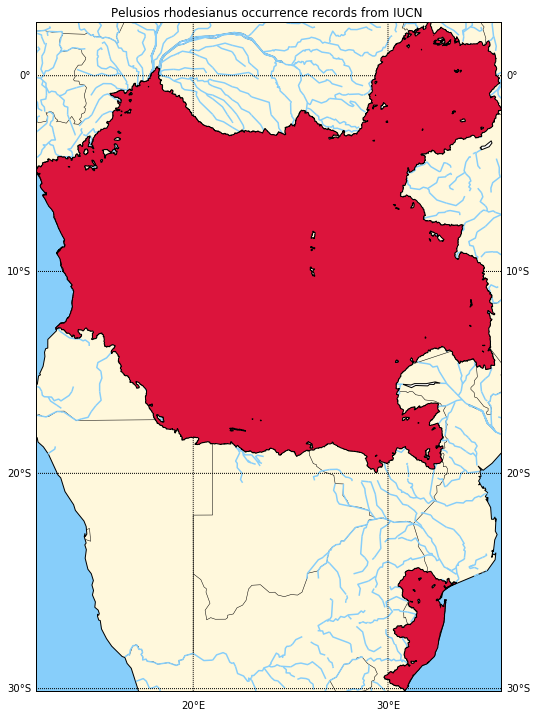

In [5]:
turtles.plot_species_occurrence()

In [6]:
turtles.save_shapefile("../data/filtered_turtles_again.shp")

Saved data: ../data/filtered_turtles_again.shp 


In [7]:
from iSDM.environment import ClimateLayer
worldclim_max_june =  ClimateLayer(file_path="../data/tmax1/tmax6.bil") 
worldclim_max_june.load_dataset()

Loading data from ../data/tmax1/tmax6.bil 
Metadata: {'affine': Affine(0.041666666666667, 0.0, -180.00000000000335,
       0.0, -0.041666666666667, 90.00000000000003),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'EHdr',
 'dtype': 'int16',
 'height': 3600,
 'nodata': -9999.0,
 'transform': (-180.00000000000335,
               0.041666666666667,
               0.0,
               90.00000000000003,
               0.0,
               -0.041666666666667),
 'width': 8640} 
Resolution: (0.041666666666667, 0.041666666666667) 
Bounds: BoundingBox(left=-180.00000000000335, bottom=-60.000000000001165, right=179.9999999999995, top=90.00000000000003) 
Dataset loaded. Use .read() or .read_masks() to access the layers.


<open RasterReader name='../data/tmax1/tmax6.bil' mode='r'>

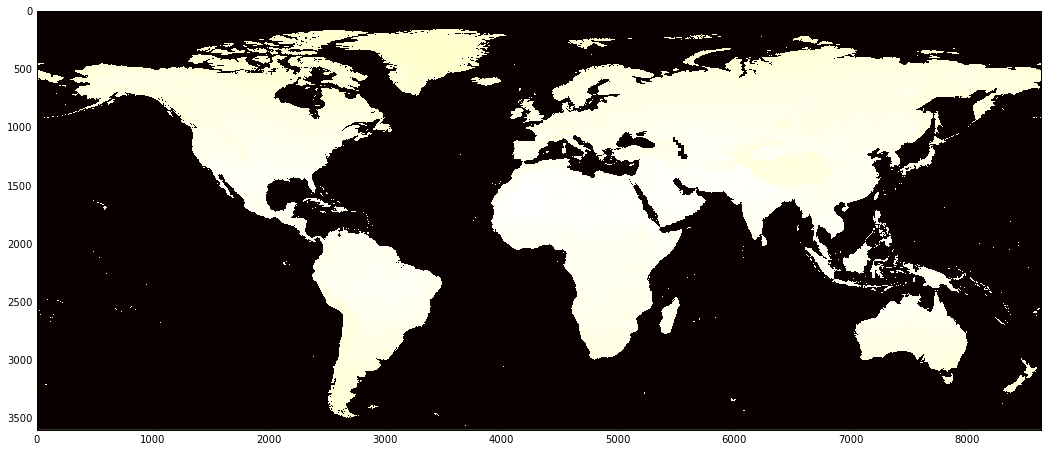

In [8]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(worldclim_max_june.get_data().read(1), cmap="hot", interpolation="none")

In [9]:
worldclim_max_june.overlay(turtles)
# if i don't limit the plot to vmin/vmax, the image is almost white, because low values are really low. 
# So we need scaling of the colormap
vmin = worldclim_max_june.masked_data.data[worldclim_max_june.masked_data.data!=worldclim_max_june.metadata['nodata']].min()
vmax=worldclim_max_june.masked_data.data.max()

Overlayed raster climate data with the given range map.
Use the .masked_data attribute to access it.


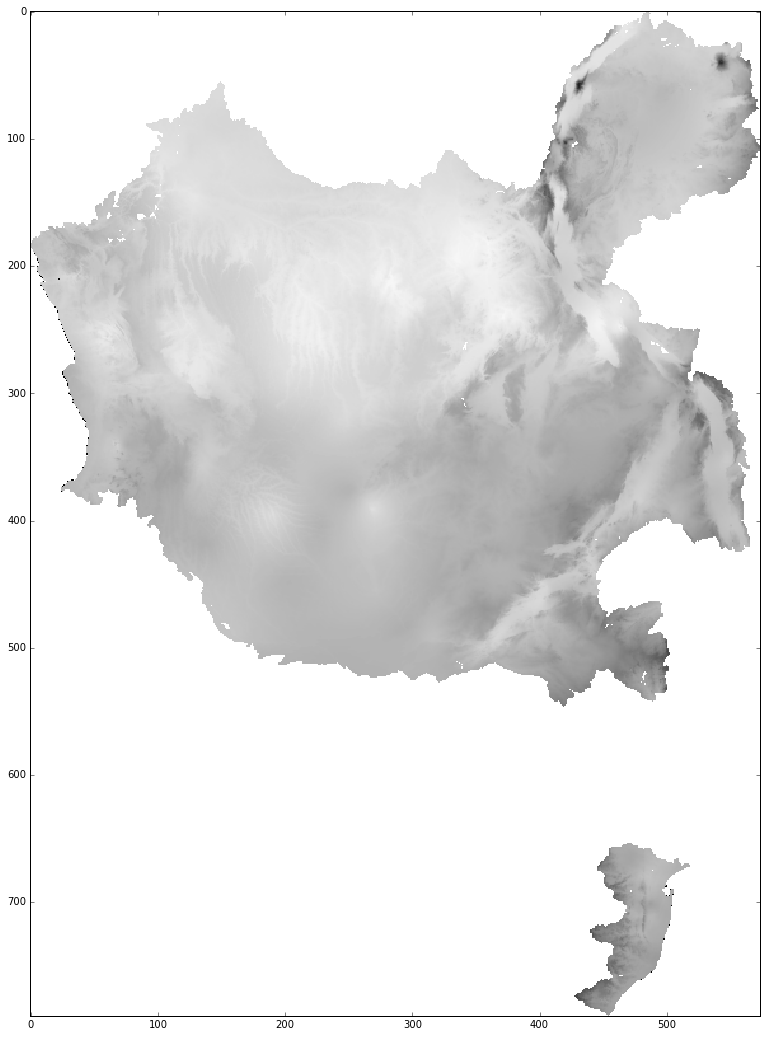

In [10]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(worldclim_max_june.masked_data, cmap="gray", interpolation="none", vmin=vmin, vmax=vmax) # vmin/vmax for better contrast?

In [11]:
worldclim_max_june.masked_data # there are .data and .mask arrays

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 999999)

In [12]:
worldclim_max_june.masked_data.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [13]:
worldclim_max_june.masked_data.data

array([[  274,   275,   275, ...,   335,   337,   338],
       [  274,   275,   275, ...,   333,   335,   336],
       [  277,   278,   278, ...,   331,   333,   335],
       ..., 
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999],
       [-9999, -9999, -9999, ..., -9999, -9999, -9999]], dtype=int16)

In [43]:
# convert to lower resolution?
worldclim_max_june.reproject(destination_file="../data/reprojected.adf", resolution=1, driver='AIG')

Calculated default transformation:
Affine:
| 1.00, 0.00,-180.00|
| 0.00,-1.00, 90.00|
| 0.00, 0.00, 1.00| 
 width=366, height=156
Reprojected data in ../data/reprojected.adf 


In [45]:
# load the lower resolution file? or should reprojecting "overwrite" the original data
worldclim_max_june.load_dataset("../data/reprojected.adf")

Loading data from ../data/reprojected.adf 
Metadata: {'affine': Affine(1.0, 0.0, -180.000000000003,
       0.0, -1.0, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'EHdr',
 'dtype': 'int16',
 'height': 156,
 'nodata': -9999.0,
 'transform': (-180.000000000003, 1.0, 0.0, 90.0, 0.0, -1.0),
 'width': 366} 
Resolution: (1.0, 1.0) 
Bounds: BoundingBox(left=-180.000000000003, bottom=-66.0, right=185.999999999997, top=90.0) 
Dataset loaded. Use .read() or .read_masks() to access the layers.


<open RasterReader name='../data/reprojected.adf' mode='r'>

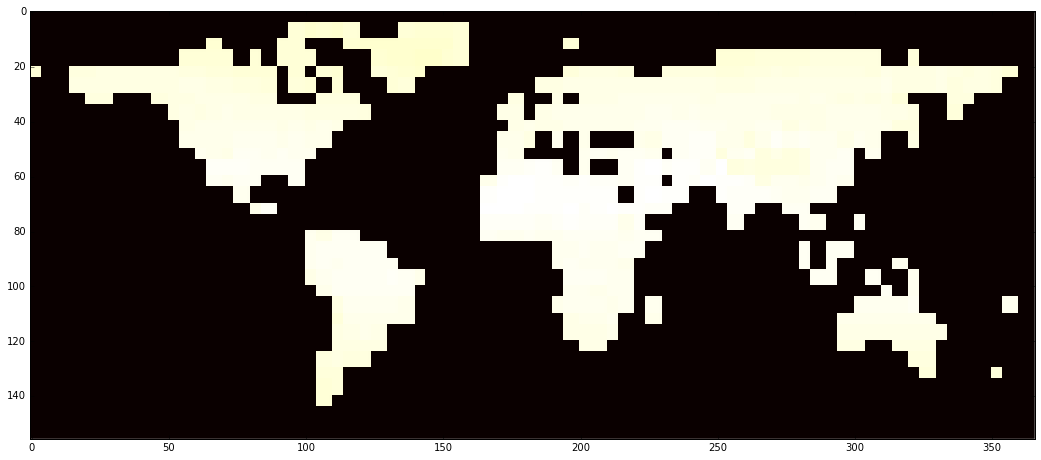

In [46]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(worldclim_max_june.get_data().read(1), cmap="hot", interpolation="none")

In [47]:
worldclim_max_june.overlay(turtles)
# if i don't limit the plot to vmin/vmax, the image is almost white, because low values are really low. 
# So we need scaling of the colormap
vmin = worldclim_max_june.masked_data.data[worldclim_max_june.masked_data.data!=worldclim_max_june.metadata['nodata']].min()
vmax=worldclim_max_june.masked_data.data.max()

Overlayed raster climate data with the given range map.
Use the .masked_data attribute to access it.


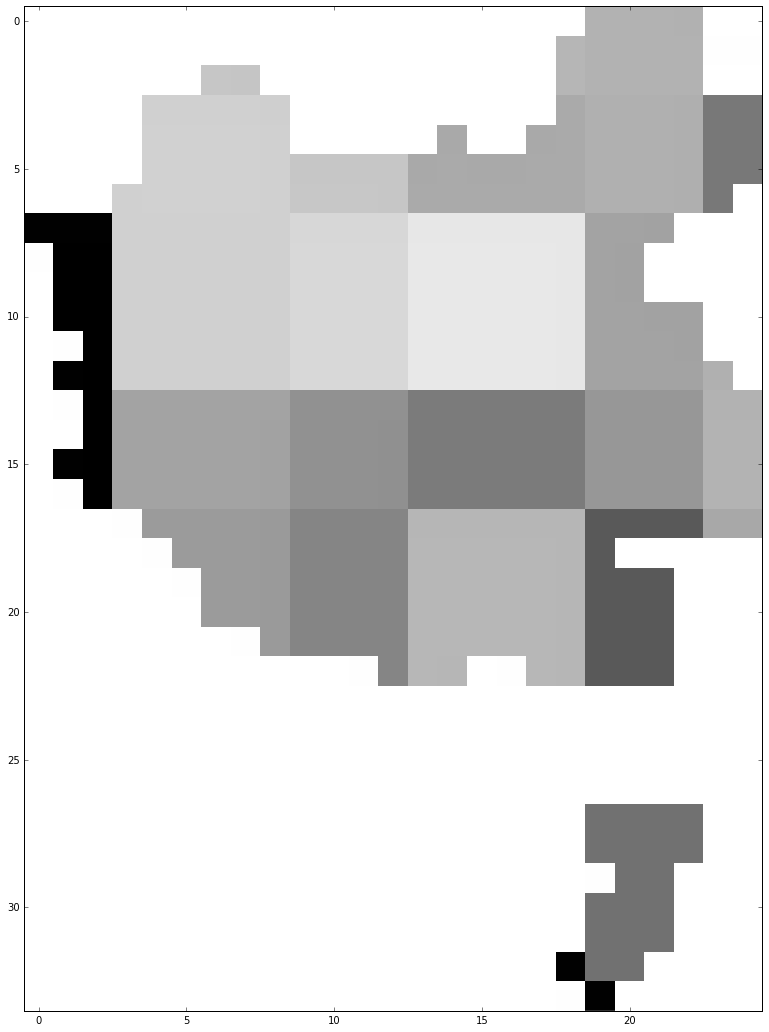

In [48]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(worldclim_max_june.masked_data, cmap="gray", interpolation="none", vmin=vmin, vmax=vmax) # vmin/vmax for better contrast?

NameError: name 'final_masked_data' is not defined

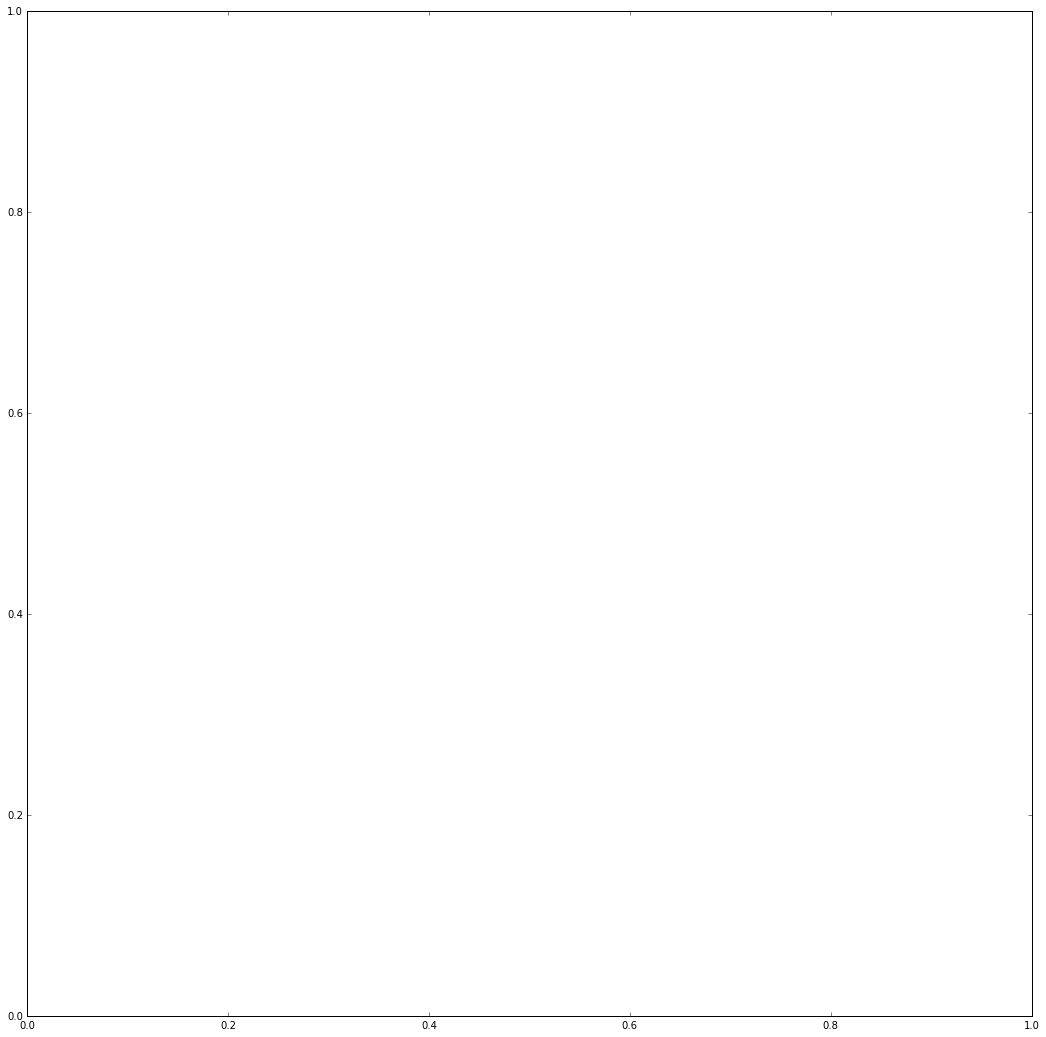

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(final_masked_data[0], cmap="gray", interpolation="none", vmin=vmin, vmax=vmax) # vmin/vmax for better contrast?
ax.imshow(final_masked_data[1], cmap="gray", interpolation="none", vmin=vmin, vmax=vmax) # vmin/vmax for better contrast?

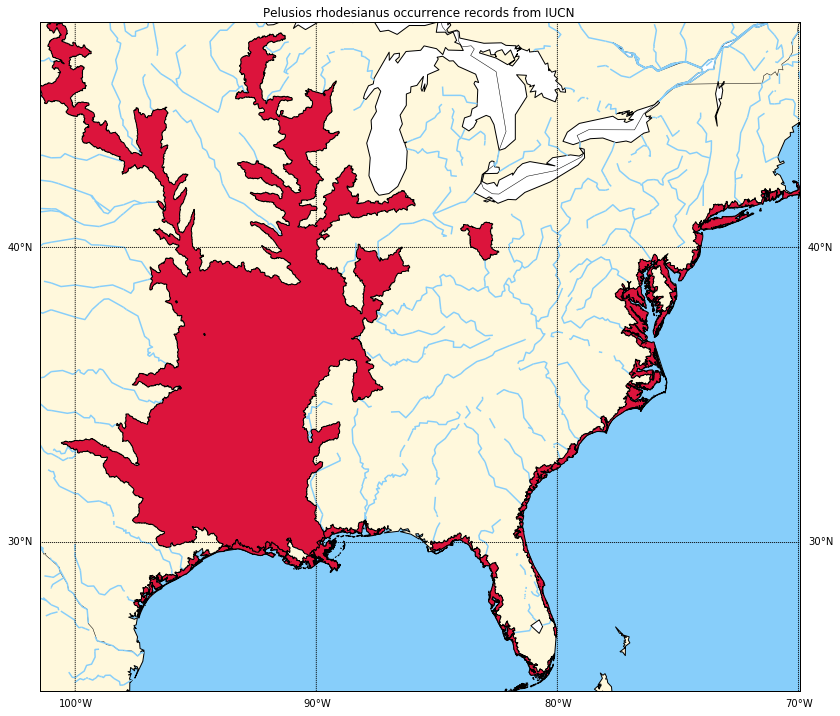

In [88]:
turtles.plot_species_occurrence()

In [89]:
turtles.save_shapefile("../data/filtered_turtles_multiple.shp")

Saved data: ../data/filtered_turtles_multiple.shp 
